<a href="https://colab.research.google.com/github/ArtuomMerkulov/DataWagon/blob/main/Hackathon_DataWagon_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Трек 1 - ПГК Оракул / Прогнозирование спроса на грузовые ЖД перевозки

# Импорты необходимых билиотек

In [ ]:
# Относительные ссылки, включая импорты, относительно корневой папки проекта
import os
os.chdir(os.path.dirname(os.getcwd()))

from datetime import datetime

In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
from phik import report, phik_matrix
from sklearn.cluster import KMeans
import sweetviz as sv

#from joblib import dump
import pickle
import math
import time
import re

# импортируем функции из statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm
from scipy import stats

# импорт моделей
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# предварительная обработка
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler)

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# кроссвалидация
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
    TimeSeriesSplit)

# метрики
from sklearn.metrics import (
    make_scorer,
    mean_absolute_percentage_error,
    mean_absolute_error,
    mean_squared_error)

# настройки
import warnings
warnings.filterwarnings("ignore")
#from skimpy import clean_columns
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# константа верхний регистр
RANDOM_STATE = 42

## Загрузка данных.
   - предварительное изучение данных
   - очистка от избыточной информации
   - формирование общего датасета для дальнейшего исследование и предобработки

In [ ]:
fact_train_test = pd.read_csv("C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\fact_train_test.csv", sep=";", decimal=",", encoding="windows-1251")
client = pd.read_csv( "C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\client_mapping.csv", sep=";", decimal=",", encoding="windows-1251")
freight = pd.read_csv("C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\freight_mapping.csv", sep=";", decimal=",", encoding="windows-1251")
station = pd.read_csv("C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\station_mapping.csv", sep=";", decimal=",", encoding="windows-1251")
#forecast_example = pd.read_csv("C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\forecast_example.csv", sep=";", decimal=",", encoding="windows-1251")

In [ ]:
fact_train_test.head()

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1


In [ ]:
client.head()

,client_sap_id,holding_name
0,0,330
1,1,1319
2,2,896
3,3,395
4,4,1629


In [ ]:
freight.head()

,freight_id,freight_group_name
0,0,0
1,1,14
2,2,5
3,3,5
4,4,5


In [ ]:
station.head()

,station_id,department_name,railway_name
0,0,0,0
1,1,107,25
2,2,107,25
3,3,164,38
4,4,81,17


# Объединение данных

In [ ]:
def add_master_data_mappings(df: pd.DataFrame) -> pd.DataFrame:

    # Клиент - холдинг
    df = pd.merge(df, client, how="left", on="client_sap_id")

    # Груз
    df = pd.merge(df, freight, how="left", on="freight_id")

    # Станции
    df = pd.merge(
        df,
        station.add_prefix("sender_"),
        how="left",
        on="sender_station_id",
    )
    df = pd.merge(
        df,
        station.add_prefix("recipient_"),
        how="left",
        on="recipient_station_id",
    )

    return df

In [ ]:
df = add_master_data_mappings(fact_train_test)

In [ ]:
df

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1,1423.0,21,153,12,75,4
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3,1423.0,21,153,12,99,23
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1,1423.0,30,153,12,16,11
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1,1423.0,30,153,12,118,11
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1,1423.0,30,153,12,94,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559227,2023-03-01,1,5,2,1346,1482,31438,31482,0,69.0,1,2226.0,22,73,14,143,35
3559228,2023-03-01,1,5,2,1346,1492,31438,36091,27275,70.0,1,2226.0,22,73,14,79,10
3559229,2023-03-01,1,5,2,1346,1492,31438,35450,27275,70.0,1,2226.0,22,73,14,104,10
3559230,2023-03-01,1,5,2,1346,1492,31438,31482,0,207.0,3,2226.0,22,73,14,143,35


In [ ]:
# функция первичного знакомства с данными
def express_info(data, name):
    print(f'Информация о {name}:')
    data.info()
    display(data.head(5))
    print()

In [ ]:
express_info(df, 'общая таблица')

Информация о общая таблица:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3559232 entries, 0 to 3559231
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   period                     object 
 1   rps                        int64  
 2   podrod                     int64  
 3   filial                     int64  
 4   client_sap_id              int64  
 5   freight_id                 int64  
 6   sender_station_id          int64  
 7   recipient_station_id       int64  
 8   sender_organisation_id     int64  
 9   real_weight                float64
 10  real_wagon_count           int64  
 11  holding_name               float64
 12  freight_group_name         int64  
 13  sender_department_name     int64  
 14  sender_railway_name        int64  
 15  recipient_department_name  int64  
 16  recipient_railway_name     int64  
dtypes: float64(2), int64(14), object(1)
memory usage: 461.6+ MB


,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1,1423.0,21,153,12,75,4
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3,1423.0,21,153,12,99,23
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1,1423.0,30,153,12,16,11
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1,1423.0,30,153,12,118,11
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1,1423.0,30,153,12,94,39


In [ ]:
# сделаем дату индексом и переведем в объект datetime
df.set_index('period', inplace=True)
df.index = pd.to_datetime(df.index)

In [ ]:
# наличие пропусков в индексе DataFrame
has_missing_index = df.index.isna().any()

if has_missing_index:
    print("В индексе есть пропущенные значения.")
else:
    print("Пропущенных значений в индексе нет.")

Пропущенных значений в индексе нет.


In [ ]:
# проверим последовательность данных
print("Индекс монотонно возрастающий:", df.index.is_monotonic_increasing)

Индекс монотонно возрастающий: True


In [ ]:
print ('Начало временного ряда: ', df.index.min())
print ('Конец временного ряда: ', df.index.max())

Начало временного ряда:  2012-07-01 00:00:00
Конец временного ряда:  2023-03-01 00:00:00


In [ ]:
#report = sv.analyze([df, "Wagon"])

In [ ]:
#report.show_html('common analysis.html')

In [ ]:
def research(data, name, figsize, silent):
    # Выбор только числовых столбцов
    numeric_data = data.select_dtypes(include=[np.number])

    print(f'Размер данных:      {numeric_data.shape}')
    print(f'Количество явных дубликатов: {numeric_data.duplicated().sum()}')
    print(f'Наличие пропусков:           {numeric_data.isna().sum().sum()}')
    print('Пропущенные данные (в процентном соотношении):')

    logging.getLogger('matplotlib.font_manager').disabled = True
    print(round(numeric_data.isna().mean()*100).sort_values(ascending=False).head(15))

    if not silent:
        print(f'\nПроверка структуры {name}:')
        numeric_data.hist(linewidth=2, histtype='step', figsize=figsize)
        plt.suptitle(f'Гистограмма распределения {name}', y=0.95, fontsize=12)
        plt.show()

    if silent:
        print(f'Корреляция {name}')
        display(numeric_data.corr().round(3)\
                .style\
                .background_gradient(cmap='Pastel2', low= 0, high = 1, axis = 0, subset = None))

    #тепловая карта корреляций
    plt.figure(figsize=(12, 12))
    matrix = np.triu(numeric_data.corr())
    heatmap = sns.heatmap(numeric_data.corr(), annot=True, fmt='.2g',
                      mask=matrix, square=True,
                      cmap='GnBu',  cbar=False,
                      xticklabels=True, yticklabels=True , vmin=0, vmax=1, center= 0)
    plt.suptitle(f'Тепловая карта матрицы корреляции {name}', y=0.90, fontsize=12)
    plt.show()
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    display(numeric_data.describe())

    if not silent:
        display(data.head(5))


Размер данных:      (3559232, 16)
Количество явных дубликатов: 683095
Наличие пропусков:           1277095
Пропущенные данные (в процентном соотношении):
holding_name                 36.0
rps                           0.0
podrod                        0.0
filial                        0.0
client_sap_id                 0.0
freight_id                    0.0
sender_station_id             0.0
recipient_station_id          0.0
sender_organisation_id        0.0
real_weight                   0.0
real_wagon_count              0.0
freight_group_name            0.0
sender_department_name        0.0
sender_railway_name           0.0
recipient_department_name     0.0
dtype: float64

Проверка структуры общая таблица:


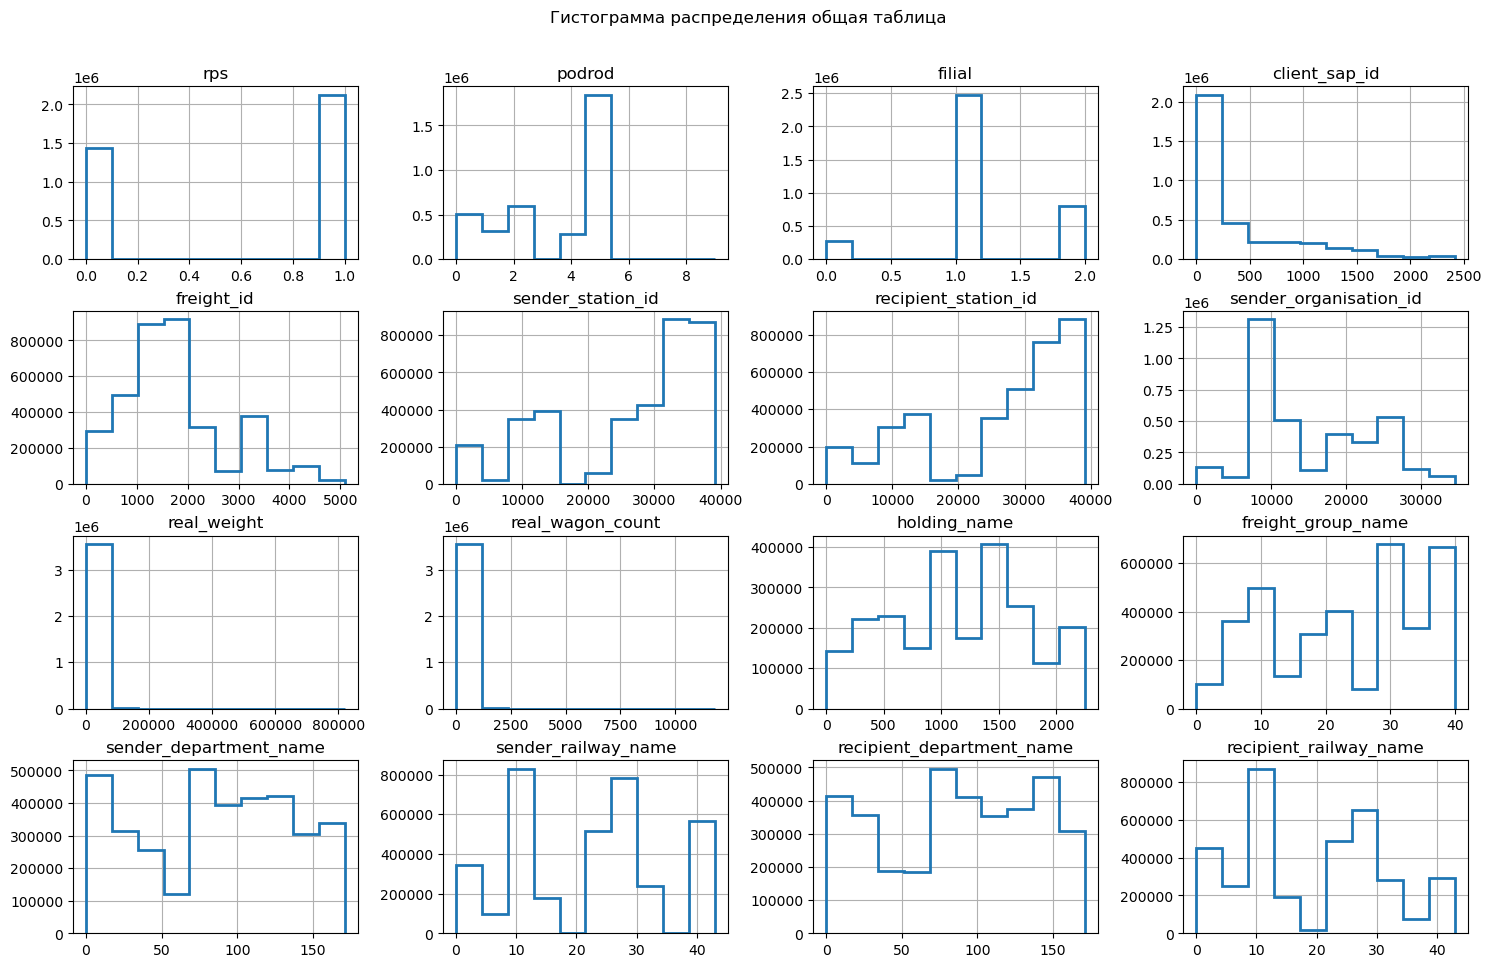

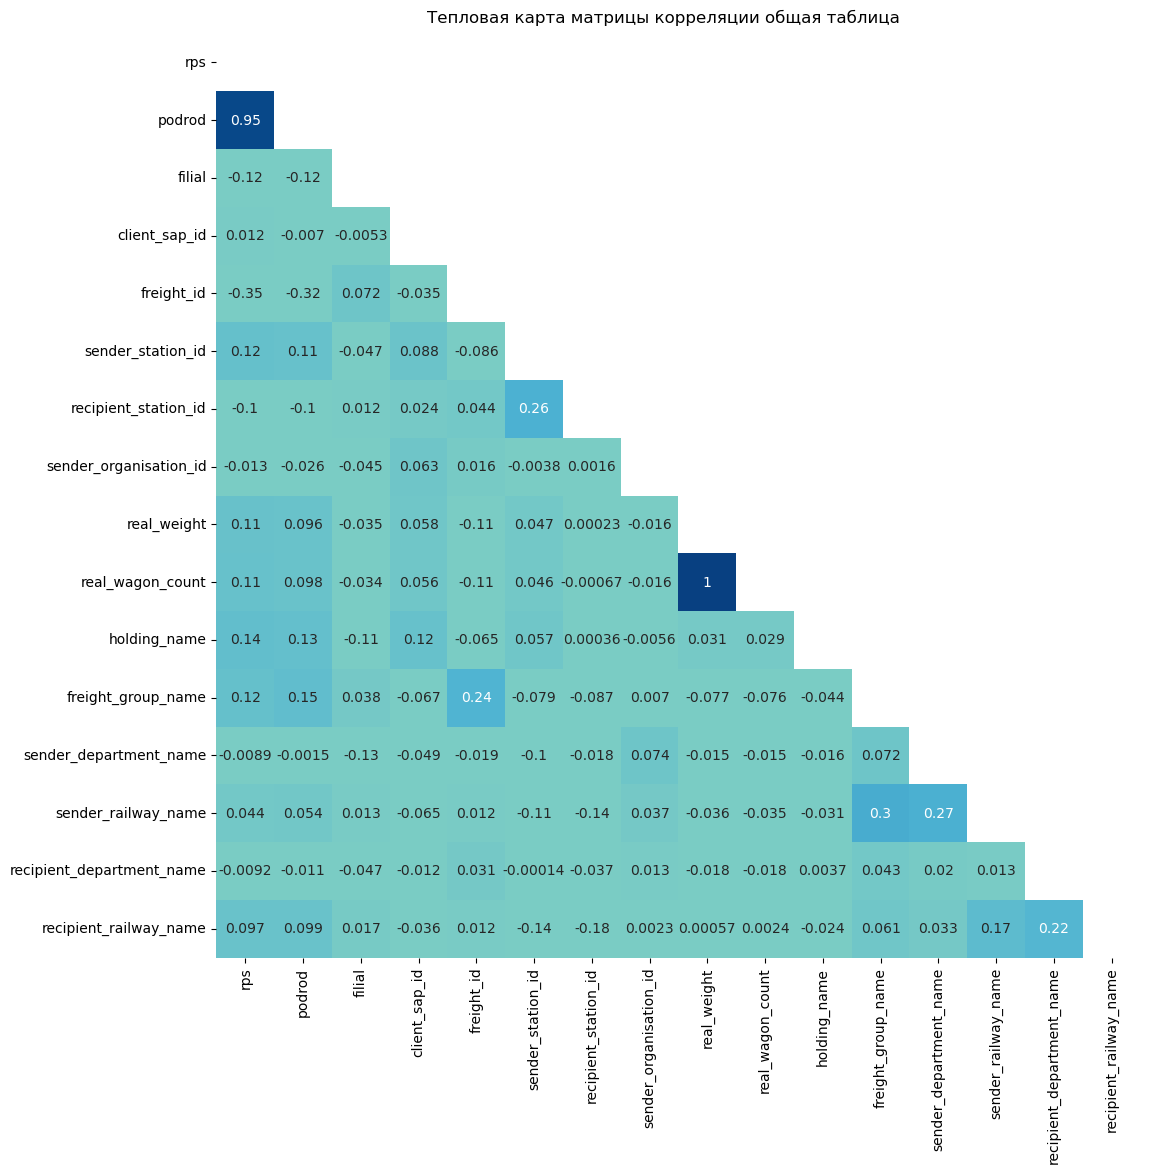

,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
count,3559232.000,3559232.000,3559232.000,3559232.000,3559232.000,3559232.000,3559232.000,3559232.000,3559232.000,3559232.000,2282137.000,3559232.000,3559232.000,3559232.000,3559232.000,3559232.000
mean,0.598,3.338,1.149,386.569,1712.424,26281.220,25981.680,14996.810,1349.654,19.888,1129.518,23.453,86.119,22.271,87.678,19.432
std,0.490,1.965,0.531,539.873,1029.591,11109.796,11461.032,8048.006,9062.866,130.152,574.514,11.954,48.859,12.381,49.134,11.901
min,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,0.000,-6.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,2.000,1.000,-1.000,1059.000,14272.000,13731.000,7856.000,65.000,1.000,602.000,11.000,43.000,10.000,43.000,10.000
50%,1.000,5.000,1.000,108.000,1622.000,30519.000,30790.000,12026.000,130.000,2.000,1141.000,22.000,93.000,25.000,94.000,22.000
75%,1.000,5.000,1.000,601.000,2219.000,35196.000,35196.000,22011.000,399.000,6.000,1560.000,34.000,130.000,30.000,133.000,29.000
max,1.000,9.000,2.000,2417.000,5086.000,39123.000,39123.000,34536.000,820435.000,11809.000,2247.000,40.000,171.000,43.000,171.000,43.000


,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
period,,,,,,,,,,,,,,,,
2012-07-01,1,5,1,328,1193,30252,13005,10036,71.000,1,1423.000,21,153,12,75,4
2012-10-01,1,5,1,328,1193,30252,11376,10036,210.000,3,1423.000,21,153,12,99,23
2014-03-01,0,1,1,328,3472,30252,29548,10036,67.000,1,1423.000,30,153,12,16,11
2014-03-01,0,1,1,328,3472,30252,29158,10036,67.000,1,1423.000,30,153,12,118,11
2014-03-01,0,2,1,328,3472,30252,27484,10036,66.000,1,1423.000,30,153,12,94,39


In [ ]:
research(df, 'общая таблица', figsize=(18, 11), silent=False)

1. Дубликаты?
2. Пропуски

In [ ]:
# функция для подсчета пропусков в столбцах в процентах
def lost(data):
    if data.isna().sum().sum()>0:
        display(
            (round(data.isna().mean()*100,3))
            .to_frame()
            .rename(columns = {0:'Пропуски'})
            .query('Пропуски > 0')
            .sort_values(by = 'Пропуски', ascending = False)
            .style.background_gradient('coolwarm')
        )
    else:
        print('Пропусков нет')

In [ ]:
lost(df)

,Пропуски
holding_name,35.881000


In [ ]:
# заменим пропуски на "заглушку 0" раз нет названия у холдинга
df.fillna(0, inplace=True)

In [ ]:
# удаление дубликатов
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

0

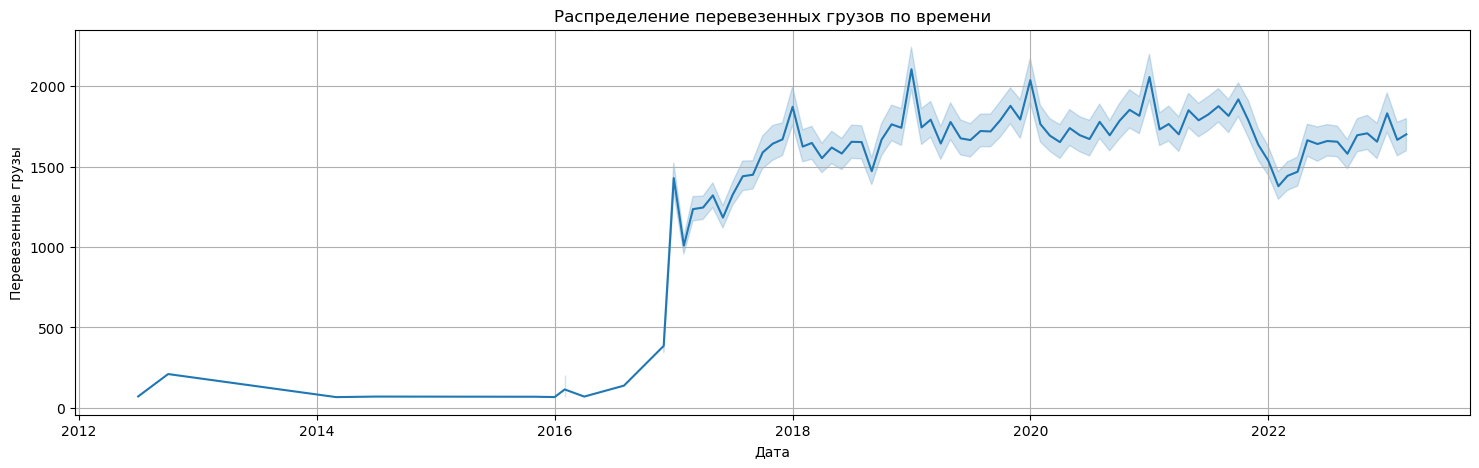

In [ ]:
plt.figure(figsize=(18, 5))
sns.lineplot(data=df, x=df.index, y="real_weight")
#sns.lineplot(data=activ_store, x=activ_store.index, y="pr_sales_in_units_log")
plt.xlabel("Дата")
plt.ylabel("Перевезенные грузы")
plt.title("Распределение перевезенных грузов по времени")
plt.grid(True)
plt.show()

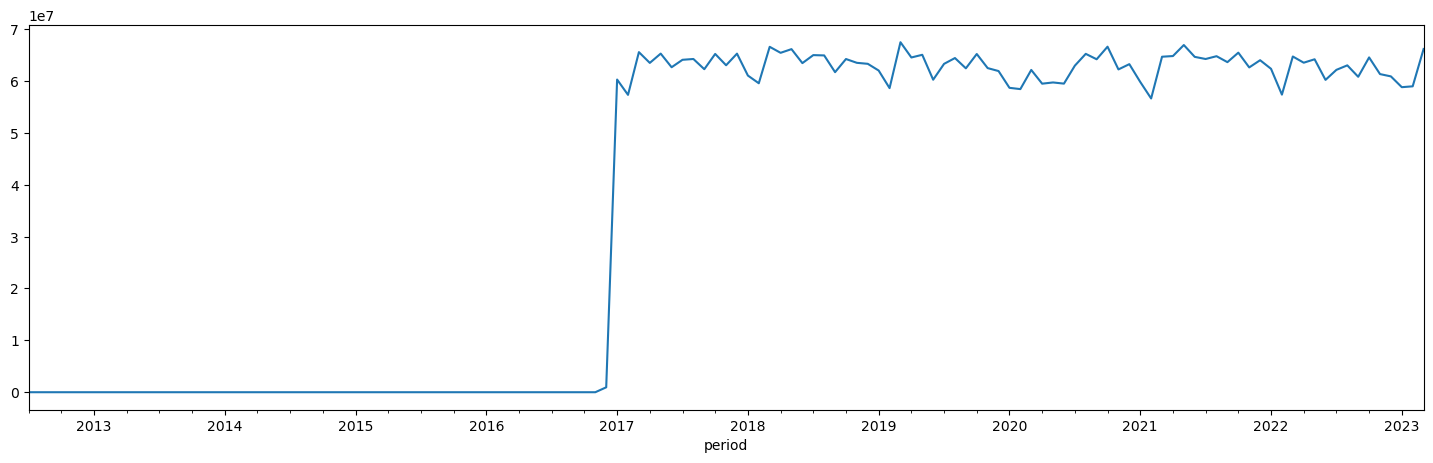

In [ ]:
# ресемплинг по месяцам
plt.figure(figsize=(18, 5))
df_m = df['real_weight'].resample('1M').sum()
df_m.plot();

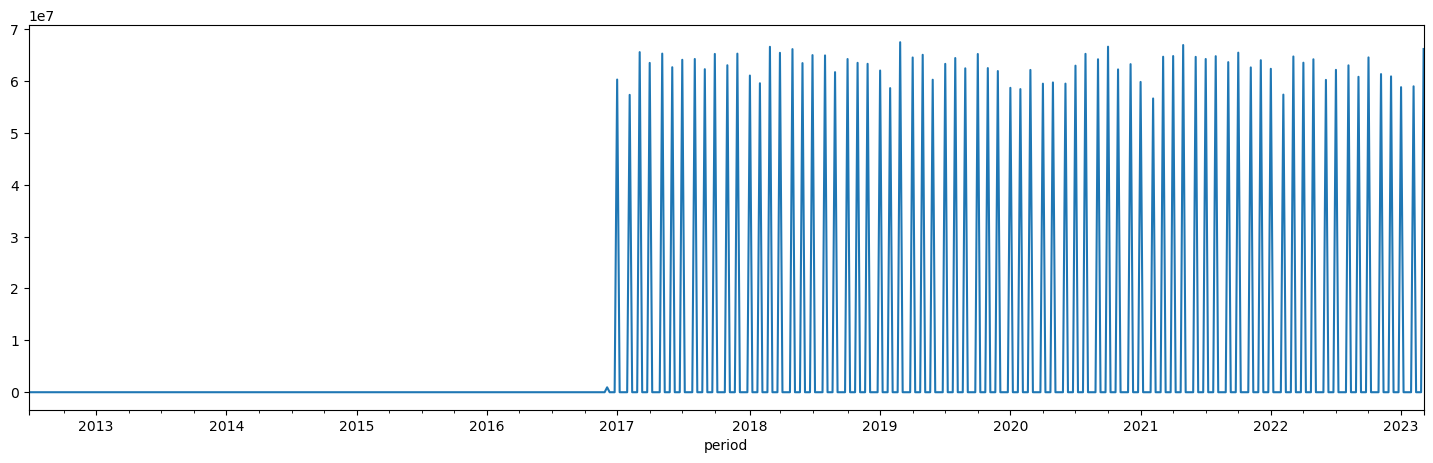

In [ ]:
# ресемплинг по неделям
plt.figure(figsize=(18, 5))
df_w = df['real_weight'].resample('1W').sum()
df_w.plot();

In [ ]:
df.index = pd.to_datetime(df.index)
# отбор строк с индексами больше 2016 года
data = df[df.index.year > 2016]
data

,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
period,,,,,,,,,,,,,,,,
2017-01-01,0,0,0,-1,23,11020,37638,672,62.000,5,0.000,5,97,23,55,3
2017-01-01,0,0,0,-1,4225,11020,37638,672,13.000,2,0.000,18,97,23,55,3
2017-01-01,0,0,0,-1,4228,11020,37638,672,6.000,0,0.000,18,97,23,55,3
2017-01-01,0,0,0,-1,4293,11020,37638,672,14.000,0,0.000,18,97,23,55,3
2017-01-01,0,0,0,-1,3320,11020,37638,672,52.000,0,0.000,20,97,23,55,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,1,5,2,1707,751,32514,35513,25891,5190.000,79,2189.000,8,119,29,104,10
2023-03-01,1,5,2,1707,921,35513,30909,32267,2435.000,37,2189.000,16,104,10,112,12
2023-03-01,1,5,2,1707,1180,35513,31188,32267,66.000,1,2189.000,21,104,10,40,12


In [ ]:
print('Исходные данные:' , len(df))
print('Очищенные данные:', len(data))
print(f'Удалено {((len(df) - len(data))/(len(df))):.2%} от исходных данных')

Исходные данные: 2876137
Очищенные данные: 2873669
Удалено 0.09% от исходных данных


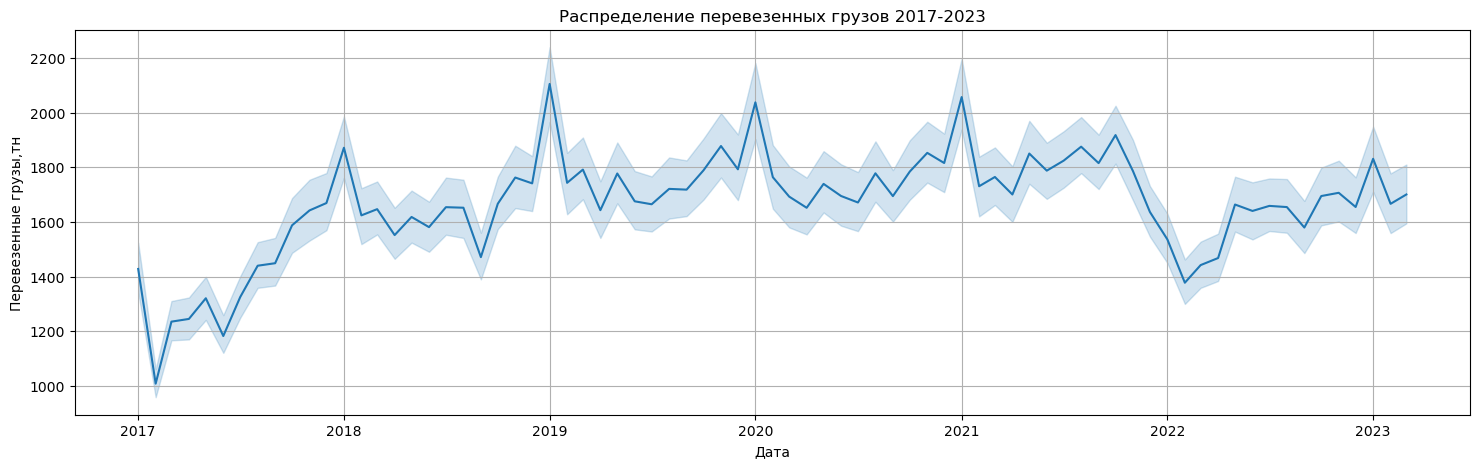

In [ ]:
plt.figure(figsize=(18, 5))
sns.lineplot(data=data, x=data.index, y="real_weight")
plt.xlabel("Дата")
plt.ylabel("Перевезенные грузы,тн")
plt.title("Распределение перевезенных грузов 2017-2023")
plt.grid(True)
plt.show()

In [ ]:
type_graph_list = ['rps','podrod','filial', 'sender_railway_name', 'recipient_railway_name']

# Изучим категориальные данные

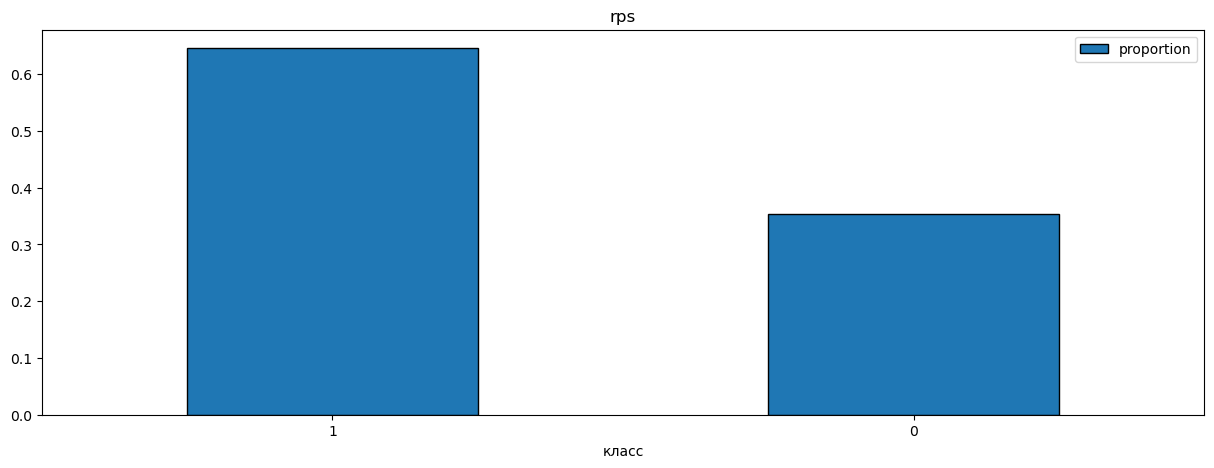

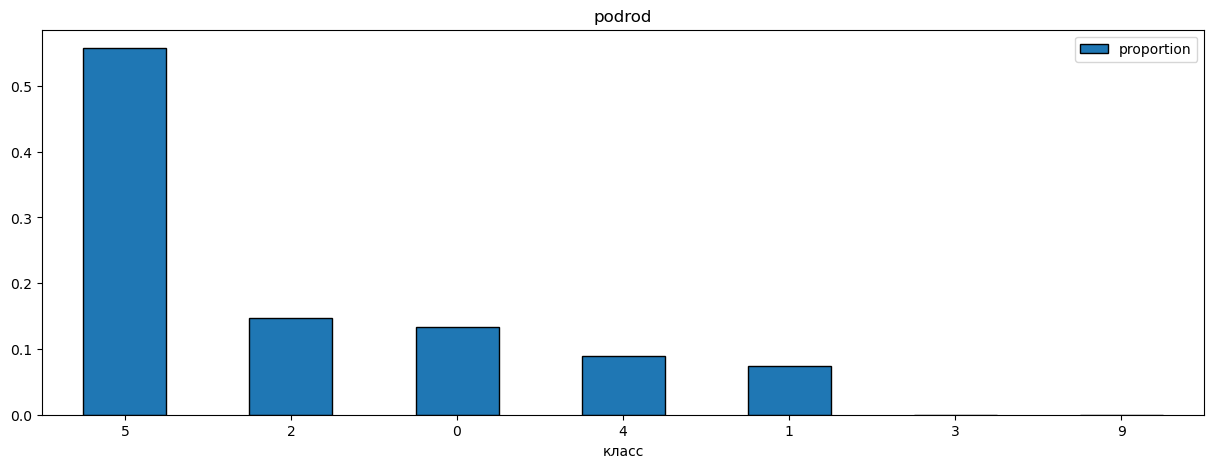

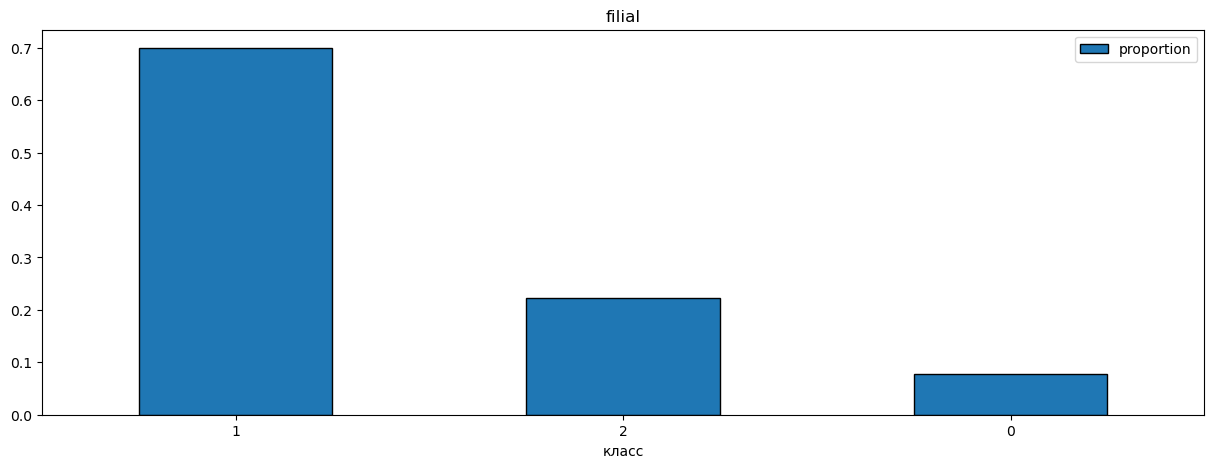

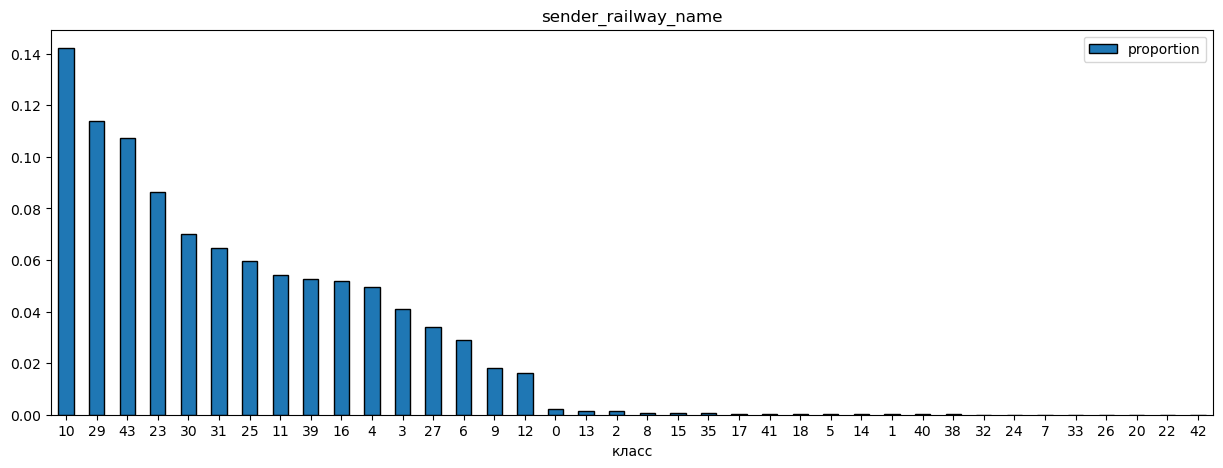

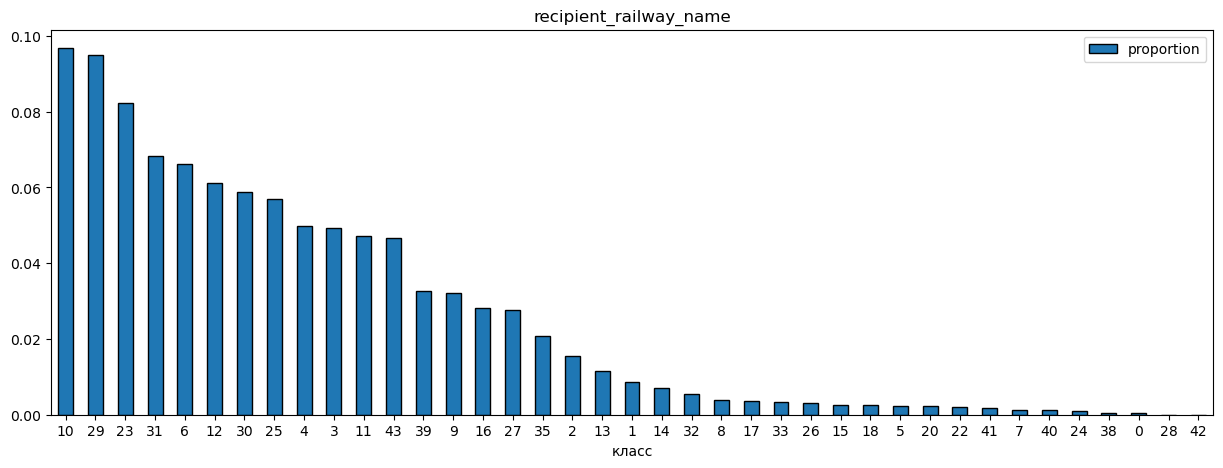

In [ ]:
for column in type_graph_list:
    class_frequency = data[column].value_counts(normalize= True).to_frame()
    #print(f'{column}',class_frequency)
    ax = class_frequency.plot(figsize=(15, 5), kind='bar', rot=0, edgecolor='black', linewidth=1)
    ax.set_xlabel('класс')
    ax.set_title(f'{column}')
    plt.show()

In [ ]:
# уникальные значения из столбца 'sender_station_id'
unique_sender_ids = data['sender_station_id'].unique()

# уникальные значения из столбца 'recipient_station_id'
unique_recipient_ids = data['recipient_station_id'].unique()

# уникальные значения
print("Уникальные значения sender_station_id:", unique_sender_ids)
print("Уникальные значения recipient_station_id:", unique_recipient_ids)

Уникальные значения sender_station_id: [11020 37644 13637 ...  1625 29660 27156]
Уникальные значения recipient_station_id: [37638 12300 29515 ... 12321 38189 32606]


In [ ]:
data

,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
period,,,,,,,,,,,,,,,,
2017-01-01,0,0,0,-1,23,11020,37638,672,62.000,5,0.000,5,97,23,55,3
2017-01-01,0,0,0,-1,4225,11020,37638,672,13.000,2,0.000,18,97,23,55,3
2017-01-01,0,0,0,-1,4228,11020,37638,672,6.000,0,0.000,18,97,23,55,3
2017-01-01,0,0,0,-1,4293,11020,37638,672,14.000,0,0.000,18,97,23,55,3
2017-01-01,0,0,0,-1,3320,11020,37638,672,52.000,0,0.000,20,97,23,55,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,1,5,2,1707,751,32514,35513,25891,5190.000,79,2189.000,8,119,29,104,10
2023-03-01,1,5,2,1707,921,35513,30909,32267,2435.000,37,2189.000,16,104,10,112,12
2023-03-01,1,5,2,1707,1180,35513,31188,32267,66.000,1,2189.000,21,104,10,40,12


In [ ]:
data = data.reset_index(drop=False)
data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2017-01-01,0,0,0,-1,23,11020,37638,672,62.000,5,0.000,5,97,23,55,3
1,2017-01-01,0,0,0,-1,4225,11020,37638,672,13.000,2,0.000,18,97,23,55,3
2,2017-01-01,0,0,0,-1,4228,11020,37638,672,6.000,0,0.000,18,97,23,55,3
3,2017-01-01,0,0,0,-1,4293,11020,37638,672,14.000,0,0.000,18,97,23,55,3
4,2017-01-01,0,0,0,-1,3320,11020,37638,672,52.000,0,0.000,20,97,23,55,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873664,2023-03-01,1,5,2,1707,751,32514,35513,25891,5190.000,79,2189.000,8,119,29,104,10
2873665,2023-03-01,1,5,2,1707,921,35513,30909,32267,2435.000,37,2189.000,16,104,10,112,12
2873666,2023-03-01,1,5,2,1707,1180,35513,31188,32267,66.000,1,2189.000,21,104,10,40,12
2873667,2023-03-01,1,5,2,1346,1482,31438,31482,0,69.000,1,2226.000,22,73,14,143,35


# Группировка по направлениям

In [ ]:
# группировка данных по комбинации sender_station_id, recipient_station_id и freight_id
grouped_data = data.groupby(['sender_station_id', 'recipient_station_id', 'freight_id', 'filial']).size().reset_index(name='count')
grouped_data

,sender_station_id,recipient_station_id,freight_id,filial,count
0,0,0,5,2,1
1,0,0,39,2,1
2,0,0,313,2,1
3,0,0,375,2,1
4,0,0,2357,2,1
...,...,...,...,...,...
422178,39123,39036,1184,2,8
422179,39123,39036,1193,1,1
422180,39123,39036,1649,1,8
422181,39123,39036,2376,1,1


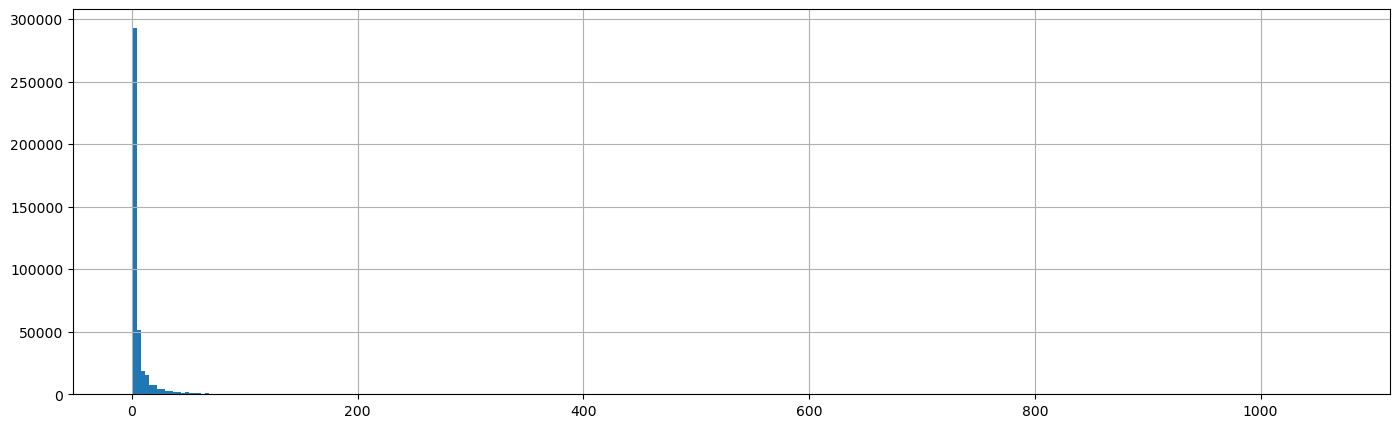

In [ ]:
# гистограмма для столбца 'count'
grouped_data['count'].hist(bins=300, figsize=(17,5));

In [ ]:
grouped_data.sort_values(by=('count'), ascending=False)

,sender_station_id,recipient_station_id,freight_id,filial,count
394041,37799,37853,349,1,1062
365052,36256,38063,349,1,700
352341,35748,38905,729,1,674
351257,35748,4042,729,1,671
409409,38760,38966,349,2,664
...,...,...,...,...,...
200812,29002,13667,1430,1,1
200814,29002,13731,1430,1,1
200816,29002,14272,1649,2,1
200820,29002,23967,2219,1,1


In [ ]:
# хранение результатов
count_occurrences = {}
total_occurrences = 0
# сколько раз использовался маршрут (количество раз для каждого значения 'count')
for i in range(1, 6):
    count_occurrences[i] = (grouped_data['count'] == i).sum()
    total_occurrences += count_occurrences[i]

# результаты
for count_value, occurrences in count_occurrences.items():
    print(f"Количество раз, когда маршрут использовался {count_value} раз: {occurrences}")

print(f"\nВсего: {total_occurrences}")

Количество раз, когда маршрут использовался 1 раз: 160941
Количество раз, когда маршрут использовался 2 раз: 68860
Количество раз, когда маршрут использовался 3 раз: 37987
Количество раз, когда маршрут использовался 4 раз: 25328
Количество раз, когда маршрут использовался 5 раз: 17831

Всего: 310947


In [ ]:
# интервалы для разделения на категории
bins = [0, 11, 39, float('inf')]
labels = [1, 2, 3]

# объединение группированных данных с исходным DataFrame по ключам sender_station_id, recipient_station_id и freight_id
merged_data = pd.merge(data, grouped_data[['sender_station_id', 'recipient_station_id', 'freight_id', 'filial', 'count']],
                       on=['sender_station_id', 'recipient_station_id', 'freight_id', 'filial'], how='left')

# добавление нового столбца 'count_category' с соответствующими значениями
merged_data['count_category'] = pd.cut(merged_data['count'], bins=bins, labels=labels, right=False)
merged_data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,count,count_category
0,2017-01-01,0,0,0,-1,23,11020,37638,672,62.000,5,0.000,5,97,23,55,3,26,2
1,2017-01-01,0,0,0,-1,4225,11020,37638,672,13.000,2,0.000,18,97,23,55,3,1,1
2,2017-01-01,0,0,0,-1,4228,11020,37638,672,6.000,0,0.000,18,97,23,55,3,2,1
3,2017-01-01,0,0,0,-1,4293,11020,37638,672,14.000,0,0.000,18,97,23,55,3,1,1
4,2017-01-01,0,0,0,-1,3320,11020,37638,672,52.000,0,0.000,20,97,23,55,3,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873664,2023-03-01,1,5,2,1707,751,32514,35513,25891,5190.000,79,2189.000,8,119,29,104,10,113,3
2873665,2023-03-01,1,5,2,1707,921,35513,30909,32267,2435.000,37,2189.000,16,104,10,112,12,28,2
2873666,2023-03-01,1,5,2,1707,1180,35513,31188,32267,66.000,1,2189.000,21,104,10,40,12,9,1
2873667,2023-03-01,1,5,2,1346,1482,31438,31482,0,69.000,1,2226.000,22,73,14,143,35,2,1


In [ ]:
# количества значений в каждой категории 'count_category'
count_category_counts = merged_data['count_category'].value_counts()

# Вывести результат
print("Количество значений в каждой категории count_category:")
print(count_category_counts)

Количество значений в каждой категории count_category:
count_category
2    965210
1    962270
3    946189
Name: count, dtype: int64


# Редко используемые направления

In [ ]:
data_cat_1 = merged_data[merged_data['count_category'] == 1].copy()
data_cat_1

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,count,count_category
1,2017-01-01,0,0,0,-1,4225,11020,37638,672,13.000,2,0.000,18,97,23,55,3,1,1
2,2017-01-01,0,0,0,-1,4228,11020,37638,672,6.000,0,0.000,18,97,23,55,3,2,1
3,2017-01-01,0,0,0,-1,4293,11020,37638,672,14.000,0,0.000,18,97,23,55,3,1,1
6,2017-01-01,0,0,0,-1,3328,37644,12300,83,65.000,1,0.000,20,55,3,54,4,5,1
7,2017-01-01,0,0,0,-1,3328,37644,29515,83,64.000,1,0.000,20,55,3,24,11,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873660,2023-03-01,1,5,2,768,1682,33683,33534,32415,54.000,1,2159.000,39,160,43,150,29,1,1
2873661,2023-03-01,1,5,2,768,1682,33683,34063,32415,67.000,1,2159.000,39,160,43,110,43,7,1
2873662,2023-03-01,1,5,2,768,1684,33683,1210,32415,36.000,2,2159.000,39,160,43,100,25,1,1
2873666,2023-03-01,1,5,2,1707,1180,35513,31188,32267,66.000,1,2189.000,21,104,10,40,12,9,1


# Средне используемые направления

In [ ]:
data_cat_2 = merged_data[merged_data['count_category'] == 2].copy()
data_cat_2

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,count,count_category
0,2017-01-01,0,0,0,-1,23,11020,37638,672,62.000,5,0.000,5,97,23,55,3,26,2
4,2017-01-01,0,0,0,-1,3320,11020,37638,672,52.000,0,0.000,20,97,23,55,3,24,2
5,2017-01-01,0,0,0,-1,3321,11020,37638,672,74.000,0,0.000,20,97,23,55,3,25,2
9,2017-01-01,0,0,0,-1,3328,37644,9393,672,61.000,1,0.000,20,55,3,97,23,15,2
10,2017-01-01,0,0,0,-1,3328,37644,8543,83,768.000,12,0.000,20,55,3,138,23,27,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873647,2023-03-01,1,5,2,1180,2406,14275,33809,25857,272.000,4,2117.000,35,26,30,160,43,17,2
2873654,2023-03-01,1,5,2,768,1682,33683,33120,32415,198.000,3,2159.000,39,160,43,43,29,21,2
2873663,2023-03-01,1,5,2,1707,751,27969,33693,25890,176.000,3,2189.000,8,25,27,160,43,19,2
2873665,2023-03-01,1,5,2,1707,921,35513,30909,32267,2435.000,37,2189.000,16,104,10,112,12,28,2


# Часто используемые направления

In [ ]:
data_cat_3 = merged_data[merged_data['count_category'] == 3].copy()
data_cat_3

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,count,count_category
20,2017-01-01,0,0,0,1233,543,13637,11963,4404,66.000,1,222.000,2,10,30,74,4,104,3
21,2017-01-01,0,0,0,1233,543,13637,1981,4404,396.000,6,222.000,2,10,30,130,25,61,3
24,2017-01-01,0,0,0,1233,564,13637,11748,4404,120.000,2,222.000,2,10,30,101,4,57,3
29,2017-01-01,0,0,0,1233,564,13637,9820,4404,266.000,5,222.000,2,10,30,19,23,109,3
30,2017-01-01,0,0,0,1233,564,13637,9212,4404,964.000,17,222.000,2,10,30,97,23,151,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873628,2023-03-01,1,5,2,1180,2406,14275,27184,25857,272.000,4,2117.000,35,26,30,17,39,52,3
2873629,2023-03-01,1,5,2,1180,2406,14275,27323,25857,340.000,5,2117.000,35,26,30,17,39,57,3
2873630,2023-03-01,1,5,2,1180,2406,14275,26755,25857,203.000,3,2117.000,35,26,30,86,39,48,3
2873633,2023-03-01,1,5,2,1180,2406,14275,27451,25857,272.000,4,2117.000,35,26,30,94,39,47,3


# Модель для data_cat_3 (часто используемые направления)

In [ ]:
data_cat_3['month'] = data_cat_3['period'].dt.month
data_cat_3['year'] = data_cat_3['period'].dt.year
print(data_cat_3.shape, '\n')
data_cat_3.sample(5)

(946189, 21) 



,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,...,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,count,count_category,month,year
2695817,2022-11-01,0,0,1,-1,1193,34996,11223,27612,68.000,...,0.000,21,9,10,97,23,46,3,11,2022
558262,2017-12-01,1,5,2,157,1063,33108,29542,10197,1012.000,...,1196.000,31,43,29,24,11,50,3,12,2017
2493437,2022-05-01,1,5,1,-1,1437,743,35462,27587,127.000,...,0.000,31,120,25,104,10,43,3,5,2022
2156099,2021-09-01,0,0,1,914,1513,38726,38641,10538,134.000,...,468.000,38,23,6,158,6,92,3,9,2021
377996,2017-08-01,1,5,1,-1,1540,27188,12064,4697,759.000,...,0.000,17,17,39,74,4,60,3,8,2017


In [ ]:
max(data_cat_3['period'])

Timestamp('2023-03-01 00:00:00')

In [ ]:
accuracy_granularity = [
        "rps",
        "holding_name",
        "sender_department_name",
        "recipient_department_name",
    ]
fact_value, forecast_value = "real_wagon_count", "forecast_wagon_count"

In [ ]:
data_cat_3 = data_cat_3[data_cat_3['real_wagon_count']>= 0]
df_test = data_cat_3[(data_cat_3['year']==2022) & (data_cat_3['month'] >= 4) & ((data_cat_3['month'] <= 8))]
df_train =  data_cat_3[((data_cat_3['year']==2022) & (data_cat_3['month'] < 4)) | (data_cat_3['year'] < 22)]

In [ ]:
group_cols = ['rps',
  'holding_name',
  'sender_department_name',
  'recipient_department_name',
  'client_sap_id',
  'freight_id',
  'recipient_station_id',
  'sender_station_id'
]
def get_test(data):
    year = 2023
    result_df = pd.DataFrame()
    for month in range(4, 9):
        temp = (data_cat_3[data_cat_3['month']==month].groupby(group_cols, as_index=False)
                .agg({'real_weight': 'count', 'real_wagon_count': 'sum'})
                .sort_values('real_wagon_count', ascending=False).head(10000))
        temp.loc[:, 'year'] = year
        temp.loc[:, 'month'] = month
        temp.loc[:, 'period'] = datetime(year, month, 1)
        result_df = pd.concat([result_df, temp], axis=0)
    return result_df

In [ ]:
val = get_test(data_cat_3)

In [ ]:
X_test = val.drop(['real_weight', 'real_wagon_count', 'period'], axis=1)
y_test = val['real_weight']

In [ ]:
df_train_ = data_cat_3.groupby(
    accuracy_granularity + ['year', 'month', 'client_sap_id', 'freight_id', 'recipient_station_id', 'sender_station_id'],
    as_index=False).agg({'real_weight': 'count', 'real_wagon_count': 'sum'}
                       )

In [ ]:
X_train = df_train_.drop(['real_weight', 'real_wagon_count'], axis=1)
y_train = df_train_['real_weight']

In [ ]:
X_train = X_train.astype(int)
X_test = X_test.astype(int)

In [ ]:
print('\033[1m'+ 'Обучающая выборка'+'\033[0m')
print ('Признаки:',X_train.shape, '\n', 'Целевой признак:', y_train.shape, sep='')
print('='*30)
print('\033[1m'+ 'Тестовая выборка'+'\033[0m')
print ('Признаки:',X_test.shape, '\n', 'Целевой признак:', y_test.shape, sep='')

Обучающая выборка
Признаки:(624634, 10)
Целевой признак:(624634,)
Тестовая выборка
Признаки:(50000, 10)
Целевой признак:(50000,)


In [ ]:
X_train.sample()

,rps,holding_name,sender_department_name,recipient_department_name,year,month,client_sap_id,freight_id,recipient_station_id,sender_station_id
596470,1,1989,86,148,2021,1,959,1654,10219,27369


In [ ]:
X_test.sample()

,rps,holding_name,sender_department_name,recipient_department_name,client_sap_id,freight_id,recipient_station_id,sender_station_id,year,month
10412,1,411,79,79,917,735,35755,35828,2023,7


### Модель "Cat Boost Regressor"

In [ ]:
# признаки для Регрессии КэтБуст
X_train_cbr = X_train.copy()
X_test_cbr = X_test.copy()

RMSE: 5.566352441775529

### Модель "Cat Boost Regressor" (подбор гиперпараметров для улучшения метрики)

In [ ]:
# создадим модель и передадим ей категориальные признаки
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE,
                              verbose=False,
                              cat_features= ['holding_name', 'rps', 'sender_department_name', 'recipient_department_name',
               'client_sap_id', 'freight_id', 'recipient_station_id', 'sender_station_id', 'year', 'month'])

In [ ]:
# параметры для подбора
parameters_cbr = [{'learning_rate':[0.1, 0.5, 0.8],
               'depth':[6,8,10],
               'iterations':[30, 50, 100],
               'verbose':[False]}]

In [ ]:
%%time
# подберем лучшие параметры для модели CatBoostRegressor
grid_cbr = GridSearchCV(
    estimator=model_cbr,
    param_grid=parameters_cbr,
    verbose=True,
    scoring='neg_root_mean_squared_error',  # RMSE в отрицательной форме
    n_jobs=-1
)

grid_cbr.fit(X_train_cbr, y_train)
best_cbr_model = grid_cbr.best_estimator_
rmse_cbr = grid_cbr.best_score_* -1

print('\033[1m' + 'Модель "CatBoost Regressor"' + '\033[0m')
print('\033[1m' + 'RMSE:' + '\033[0m', rmse_cbr)
print('=' * 75)
print("Лучшие параметры для CatBoost Regressor:\n", grid_cbr.best_params_)
print('=' * 75)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Модель "CatBoost Regressor"
RMSE: 0.891881370807569
Лучшие параметры для CatBoost Regressor:
 {'depth': 6, 'iterations': 30, 'learning_rate': 0.1, 'verbose': False}
CPU times: total: 56.9 s
Wall time: 27min 9s


In [ ]:
стоп

NameError: name 'стоп' is not defined

# Метрики организаторов и выгрузка

In [ ]:
forecast = pd.concat([val.reset_index(drop=True), pd.DataFrame({"forecast_wagon_count": (abs(pred))})], axis=1)

In [ ]:
forecast

In [ ]:
forecast.loc[forecast[forecast['forecast_wagon_count'] < 0].index, 'forecast_wagon_count'] = 0

In [ ]:
forecast

In [ ]:
def evaluate(fact: pd.DataFrame, forecast: pd.DataFrame, public: bool = True) -> float:
    # = Параметры для расчета метрики =
    accuracy_granularity = [
        "period",
        "rps",
        "holding_name",
        "sender_department_name",
        "recipient_department_name",
    ]
    fact_value, forecast_value = "real_wagon_count", "forecast_wagon_count"
    if public:
        metric_weight = np.array([0.0, 1.0, 0.0, 0.0, 0.0])
    else:
        metric_weight = np.array([0.1, 0.6, 0.1, 0.1, 0.1])

    # = Собственно расчет метрик =
    # 1. Добавляем сущности верхних уровней гранулярности по справочникам
    fact = add_master_data_mappings(fact)
    forecast = add_master_data_mappings(forecast)

    # print(fact.columns)
    # print(forecast.columns)

    # 2. Расчет KPI
    compare_data = pd.merge(
        fact.groupby(accuracy_granularity, as_index=False)[fact_value].sum(),
        forecast.groupby(accuracy_granularity, as_index=False)[forecast_value].sum(),
        how="outer",
        on=accuracy_granularity,
    ).fillna(0)
    # Против самых хитрых - нецелочисленный прогноз вагоноотправок не принимаем
    compare_data[fact_value] = np.around(compare_data[fact_value]).astype(int)
    compare_data[forecast_value] = np.around(compare_data[forecast_value]).astype(int)

    # 3. Рассчитаем метрики для каждого месяца в выборке
    compare_data["ABS_ERR"] = abs(
        compare_data[forecast_value] - compare_data[fact_value]
    )
    compare_data["MAX"] = abs(compare_data[[forecast_value, fact_value]].max(axis=1))
    summary = compare_data.groupby("period")[
        [forecast_value, fact_value, "ABS_ERR", "MAX"]
    ].sum()
    summary["Forecast Accuracy"] = 1 - summary["ABS_ERR"] / summary["MAX"]

    # 4. Взвесим метрики отдельных месяцев для получения одной цифры score
    score = (
        summary["Forecast Accuracy"].sort_index(ascending=True) * metric_weight
    ).sum()

    return score


def calc_score_public(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=True)

In [ ]:
accuracy_granularity = [
        "period",
        "rps",
        "holding_name",
        "sender_department_name",
        "recipient_department_name",
    ]

In [ ]:
fact = df_test.reset_index(drop=True)[accuracy_granularity + ['client_sap_id', 'freight_id', 'recipient_station_id', 'sender_station_id']]
fact

In [ ]:
fact_ = fact.drop(['holding_name', 'sender_department_name', 'recipient_department_name'], axis=1)
fact_

In [ ]:
val_ = val.drop(['holding_name', 'sender_department_name', 'recipient_department_name', 'year', 'month'], axis=1)
val

In [ ]:
val_ = val.drop(['holding_name', 'sender_department_name', 'recipient_department_name', 'year', 'month'], axis=1)
val

In [ ]:
forecast_ = forecast.drop(['holding_name', 'sender_department_name', 'recipient_department_name', 'year', 'month', 'real_weight','real_wagon_count'], axis=1)
#calc_score_public(fact_, forecast_)

In [ ]:
forecast_ = forecast_.reset_index(drop=True)[accuracy_granularity + ['client_sap_id', 'freight_id', 'recipient_station_id', 'sender_station_id']]
forecast_

In [ ]:
path = "C:/Users/Mikhail/mushroom/проекты/DataWagon/"

In [ ]:
forecast_.to_csv(path+"forecast.csv", index=False, sep=";", decimal=",", encoding="windows-1251")

# БЕЗЛАЙН

## Образец результата

прогноз на апрель - август 2023, сделанный на данных до марта включительно

In [ ]:
# Относительные ссылки, включая импорты, относительно корневой папки проекта
import os
os.chdir(os.path.dirname(os.getcwd()))

import pandas as pd
import numpy as np


In [ ]:
# Факт на задание
fact = pd.read_csv("C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\fact_train_test.csv", sep=";", decimal=",", encoding="windows-1251")
fact["period"] = fact["period"].astype("datetime64[ns]")
# fact - уже обрезанная выборка

# Пример прогноза - наивный, копия последнего факта
result = []
last_known_fact_month = fact["period"].max()
test_periods = pd.date_range(start=last_known_fact_month, periods=6, freq='MS', inclusive='right')
for period in test_periods:
    print(period)
    month_forecast = fact[fact["period"] == last_known_fact_month].reset_index(drop=True)
    month_forecast["period"] = period
    result.append(month_forecast)
result = pd.concat(result).reset_index(drop=True)
result.rename(columns={"real_wagon_count": "forecast_wagon_count", "real_weight": "forecast_weight"}, inplace=True)
result.to_csv("C:/Users/Mikhail/mushroom/проекты/DataWagon/forecast_ex.csv", index=False, sep=";", decimal=",", encoding="windows-1251")


## Оценка результата

In [ ]:
def add_master_data_mappings(df: pd.DataFrame) -> pd.DataFrame:
    # = Пути к справочникам - откорректировать если в реальной системе будут лежать по другому адресу =
    client_mapping_file = "C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\client_mapping.csv"
    freight_mapping_file = "C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\freight_mapping.csv"
    station_mapping_file = "C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\station_mapping.csv"

    # Клиент - холдинг
    client_mapping = pd.read_csv(
        client_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(df, client_mapping, how="left", on="client_sap_id")

    # Груз
    freight_mapping = pd.read_csv(
        freight_mapping_file, sep=";", decimal=",", encoding="windows-1251"
    )
    df = pd.merge(df, freight_mapping, how="left", on="freight_id")

    # Станции
    station_mapping = pd.read_csv(
        station_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("sender_"),
        how="left",
        on="sender_station_id",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("recipient_"),
        how="left",
        on="recipient_station_id",
    )

    return df


def evaluate(fact: pd.DataFrame, forecast: pd.DataFrame, public: bool = True) -> float:
    # = Параметры для расчета метрики =
    accuracy_granularity = [
        "period",
        "rps",
        "holding_name",
        "sender_department_name",
        "recipient_department_name",
    ]
    fact_value, forecast_value = "real_wagon_count", "forecast_wagon_count"
    if public:
        metric_weight = np.array([0.0, 1.0, 0.0, 0.0, 0.0])
    else:
        metric_weight = np.array([0.1, 0.6, 0.1, 0.1, 0.1])

    # = Собственно расчет метрик =
    # 1. Добавляем сущности верхних уровней гранулярности по справочникам
    fact = add_master_data_mappings(fact)
    forecast = add_master_data_mappings(forecast)

    # 2. Расчет KPI
    compare_data = pd.merge(
        fact.groupby(accuracy_granularity, as_index=False)[fact_value].sum(),
        forecast.groupby(accuracy_granularity, as_index=False)[forecast_value].sum(),
        how="outer",
        on=accuracy_granularity,
    ).fillna(0)
    # Против самых хитрых - нецелочисленный прогноз вагоноотправок не принимаем
    compare_data[fact_value] = np.around(compare_data[fact_value]).astype(int)
    compare_data[forecast_value] = np.around(compare_data[forecast_value]).astype(int)

    # 3. Рассчитаем метрики для каждого месяца в выборке
    compare_data["ABS_ERR"] = abs(
        compare_data[forecast_value] - compare_data[fact_value]
    )
    compare_data["MAX"] = abs(compare_data[[forecast_value, fact_value]].max(axis=1))
    summary = compare_data.groupby("period")[
        [forecast_value, fact_value, "ABS_ERR", "MAX"]
    ].sum()
    summary["Forecast Accuracy"] = 1 - summary["ABS_ERR"] / summary["MAX"]

    # 4. Взвесим метрики отдельных месяцев для получения одной цифры score
    score = (
        summary["Forecast Accuracy"].sort_index(ascending=True) * metric_weight
    ).sum()

    return score


def calc_score_public(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=True)


def calc_score_private(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=False)

In [ ]:
add_master_data_mappings(fact)

In [ ]:
# = Примеры файлов для проверки =
validation_file = "C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\fact_validation.csv"
forecast_file = "C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\forecast_example.csv"

# Валидационный датасет
fact = pd.read_csv(validation_file, sep=";", decimal=",", encoding="windows-1251")
# print("Валидационный датасет:", fact.shape)
# Прогноз
forecast = pd.read_csv(forecast_file, sep=";", decimal=",", encoding="windows-1251")
# print("Прогноз:", forecast.shape)

# Скорим
score_public = calc_score_public(fact, forecast)
score_private = calc_score_private(fact, forecast)
print(f"Public score: {score_public}")
print(f"Private score: {score_private}")


In [ ]:
forecast_file = pd.read_csv("C:\\Users\\Mikhail\\mushroom\\проекты\\DataWagon\\forecast_example.csv", sep=";", decimal=",", encoding="windows-1251")
forecast_file